# タイタニック生死データを機械学習し、乗客の生死を予測する

## 1. データの前処理
### 1.1 データ読み込み

In [25]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rc("font", size=14)
import seaborn as sns
sns.set(style="white") #white background style for seaborn plots
sns.set(style="whitegrid", color_codes=True)

folder='C:\\Users\\nakam\\Python\\Data\\kaggle'
os.chdir(folder)
df=pd.read_csv('train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [26]:
#データ確認

df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### 1.2 欠損値分析

In [27]:
#欠損値の確認
#Cabinは欠損値が多いので、無視する

df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

(-10, 85)

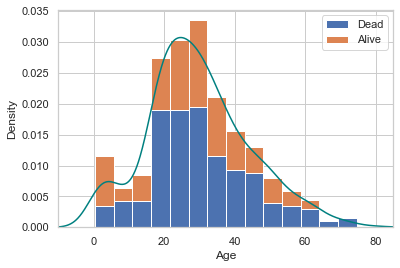

In [28]:
#Ageの欠損値処理
#ヒストグラム化してデータを確認

split_data=[]
for survived in [0,1]: #splitにsurvived=0,1のdfを格納
    split_data.append(df[df['Survived']==survived]) #Survivedでグループ分け

temp=[i["Age"].dropna() for i in split_data] #tempにsplitのデータのPlassのみ格納される

plt.hist(temp,density=True,histtype='barstacked',bins=15) #density=Trueで割合表示
plt.legend(["Dead","Alive"],loc=4) #凡例
plt.xlabel("Age") #X軸
df["Age"].plot(kind='density', color='teal') #曲線を追加
plt.xlim(-10,85) #X軸範囲を指定

In [29]:
#右にゆがんだ分布なので、平均ではなく、中央値で欠損値を補完する

print(df['Age'].mean()) #平均値
print(df['Age'].median()) #中央値

29.69911764705882
28.0


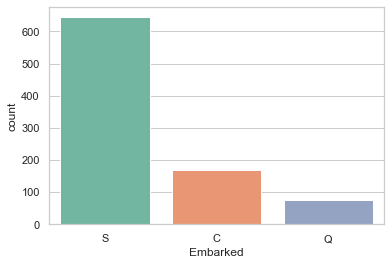

In [30]:
#Embarkedの欠損値処理
#グラフ化してデータ確認

sns.countplot(x='Embarked', data=df,palette='Set2')#paletteは色の指定
plt.show()

In [31]:
#最も多いSで補完する

df['Embarked'].value_counts().idxmax()

'S'

### 1.3 分析結果に基づき欠損値補完

In [32]:
#dfコピー
df1 = df.copy()

#欠損値補完
df1["Age"].fillna(df1["Age"].median(skipna=True), inplace=True)
df1["Embarked"].fillna(df1['Embarked'].value_counts().idxmax(), inplace=True)
df1.drop('Cabin', axis=1, inplace=True)
df1.head(6)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S
5,6,0,3,"Moran, Mr. James",male,28.0,0,0,330877,8.4583,Q


### 1.4 欠損値補完結果確認

In [33]:
#データ確認

df1.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

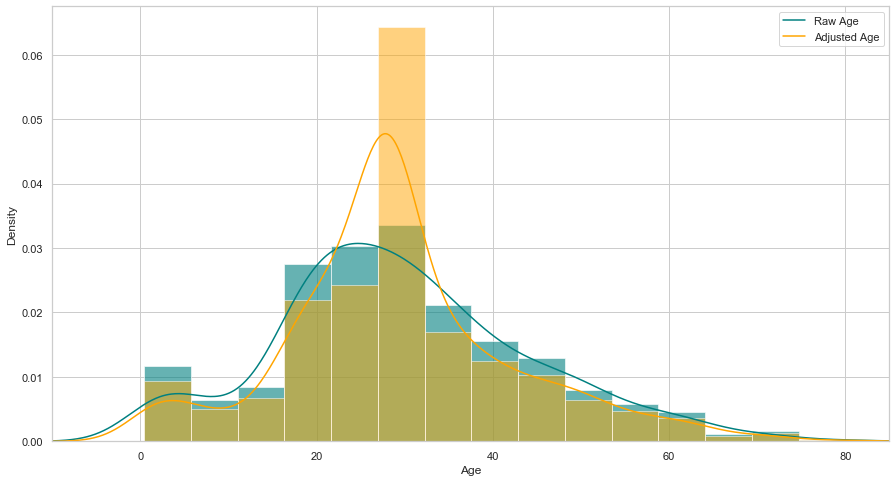

In [34]:
#Age欠損値補完結果確認

plt.figure(figsize=(15,8))
ax = df["Age"].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6) #alpha=透明度
df["Age"].plot(kind='density', color='teal')
ax = df1["Age"].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.5)
df1["Age"].plot(kind='density', color='orange')
ax.legend(['Raw Age', 'Adjusted Age'])
ax.set(xlabel='Age')
plt.xlim(-10,85)
plt.show()

### 1.5 特徴量の作成・調整

In [35]:
#特徴量生成
df1['TravelAlone']=np.where((df1["SibSp"]+df1["Parch"])>0, 0, 1)
df1['Family']=df1['SibSp']+df1['Parch']
df1.drop('SibSp', axis=1, inplace=True)
df1.drop('Parch', axis=1, inplace=True)
df1.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Embarked,TravelAlone,Family
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,A/5 21171,7.2500,S,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,PC 17599,71.2833,C,0,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,STON/O2. 3101282,7.9250,S,1,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,113803,53.1000,S,0,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,373450,8.0500,S,1,0


In [37]:
#ダミー変数作成
df2=pd.get_dummies(df1, columns=["Pclass","Embarked","Sex"])
df2.drop('Sex_female', axis=1, inplace=True)
df2.drop('PassengerId', axis=1, inplace=True)
df2.drop('Name', axis=1, inplace=True)
df2.drop('Ticket', axis=1, inplace=True)

#男女を0,1に変換は以下のように書いてもいい
#df=df.replace('male', 0).replace('female', 1)

df2.head(6)

,Survived,Age,Fare,TravelAlone,Family,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Sex_male
0,0,22.0,7.2500,0,1,0,0,1,0,0,1,1
1,1,38.0,71.2833,0,1,1,0,0,1,0,0,0
2,1,26.0,7.9250,1,0,0,0,1,0,0,1,0
3,1,35.0,53.1000,0,1,1,0,0,0,0,1,0
4,0,35.0,8.0500,1,0,0,0,1,0,0,1,1
5,0,28.0,8.4583,1,0,0,0,1,0,1,0,1


## 2. データ分析
### 2.1 Exploration of Age

(-10, 85)

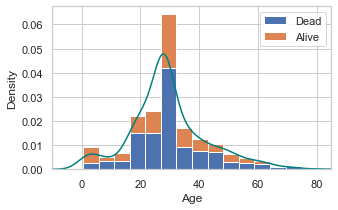

In [38]:
#ヒストグラム

split_data=[]
for survived in [0,1]: #splitにsurvived=0,1のdfを格納
    split_data.append(df2[df2['Survived']==survived]) #Survivedでグループ分け

temp=[i["Age"].dropna() for i in split_data] #tempにsplitのデータのPlassのみ格納される

plt.figure(figsize=(5,3))
plt.hist(temp,density=True,histtype='barstacked',bins=15) #density=Trueで割合表示
plt.legend(["Dead","Alive"],loc=4) #凡例
plt.xlabel("Age") #X軸
df2["Age"].plot(kind='density', color='teal') #曲線を追加
plt.xlim(-10,85) #X軸範囲を指定

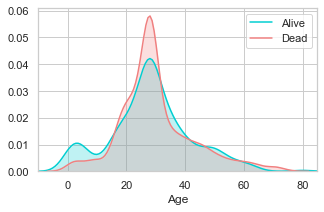

In [39]:
#分布図
#子供の生存率が高いことがわかる

plt.figure(figsize=(5,3))
ax = sns.kdeplot(df2["Age"][df2.Survived == 1], color="darkturquoise", shade=True)
sns.kdeplot(df2["Age"][df2.Survived == 0], color="lightcoral", shade=True)
plt.legend(['Alive', 'Dead'])
ax.set(xlabel='Age')
plt.xlim(-10,85)
plt.show()

      Age  Survived
0    0.42       1.0
1    0.67       1.0
2    0.75       1.0
3    0.83       1.0
4    0.92       1.0
..    ...       ...
83  70.00       0.0
84  70.50       0.0
85  71.00       0.0
86  74.00       0.0
87  80.00       1.0

[88 rows x 2 columns]


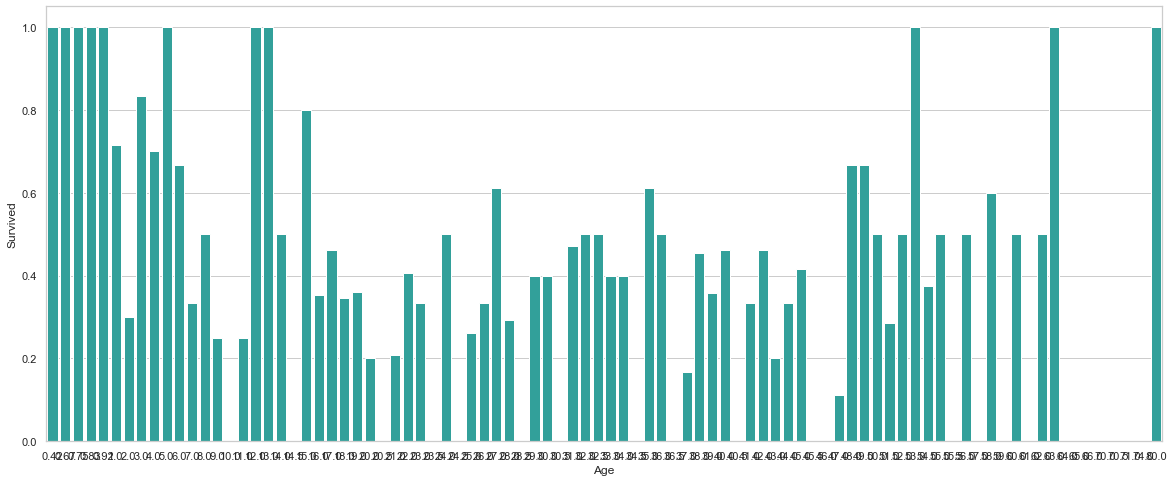

In [40]:
#Age毎の生存率をプロット

plt.figure(figsize=(20,8))
avg_survival_byage = df2[["Age", "Survived"]].groupby(['Age'], as_index=False).mean() #AgeをindexにしたくないためFalse
print(avg_survival_byage)
g = sns.barplot(x='Age', y='Survived', data=avg_survival_byage, color="LightSeaGreen")
plt.show()

In [42]:
#15歳以下の生存率が高いので、新たな特徴量を作成

df2['IsMinor']=np.where(df2['Age']<=16, 1, 0)
df2.head()

,Survived,Age,Fare,TravelAlone,Family,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Sex_male,IsMinor
0,0,22.0,7.2500,0,1,0,0,1,0,0,1,1,0
1,1,38.0,71.2833,0,1,1,0,0,1,0,0,0,0
2,1,26.0,7.9250,1,0,0,0,1,0,0,1,0,0
3,1,35.0,53.1000,0,1,1,0,0,0,0,1,0,0
4,0,35.0,8.0500,1,0,0,0,1,0,0,1,1,0


### 2.2 Exploration of Fare

(-20, 200)

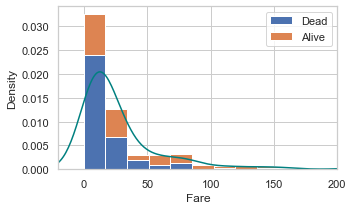

In [43]:
#ヒストグラム

split_data=[]
for survived in [0,1]: #splitにsurvived=0,1のdfを格納
    split_data.append(df2[df2['Survived']==survived]) #Survivedでグループ分け

temp=[i["Fare"].dropna() for i in split_data] #tempにsplitのデータのPlassのみ格納される

plt.figure(figsize=(5,3))
plt.hist(temp,density=True,histtype='barstacked',bins=30) #density=Trueで割合表示
plt.legend(["Dead","Alive"],loc=4) #凡例
plt.xlabel("Fare") #X軸
df2["Fare"].plot(kind='density', color='teal') #曲線を追加
plt.xlim(-20,200) #X軸範囲を指定

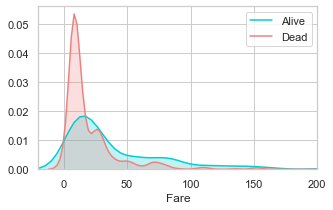

In [44]:
#分布図
#安い運賃の死亡率が高い

plt.figure(figsize=(5,3))
ax = sns.kdeplot(df2["Fare"][df2.Survived == 1], color="darkturquoise", shade=True)
sns.kdeplot(df2["Fare"][df2.Survived == 0], color="lightcoral", shade=True)
plt.legend(['Alive', 'Dead'])
ax.set(xlabel='Fare')
plt.xlim(-20,200)
plt.show()

### 2.3 Exploration of Passenger Class

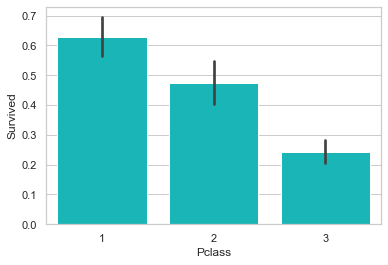

In [45]:
#クラス毎の生存率
#First Classが最も生存率が高い

sns.barplot('Pclass', 'Survived', data=df1, color="darkturquoise")
plt.show()

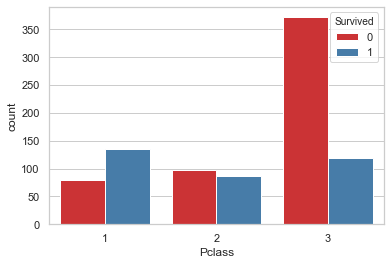

In [46]:
#棒グラフ

sns.countplot(x="Pclass", hue="Survived", palette="Set1", data=df1)

### 2.4 Exploration of Embarked Port

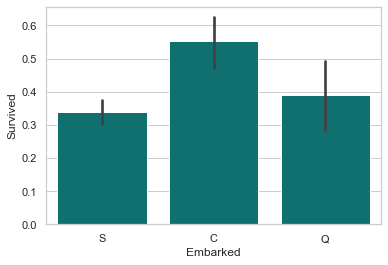

In [47]:
#搭乗地区毎の生存率

sns.barplot('Embarked', 'Survived', data=df1, color="teal")
plt.show()

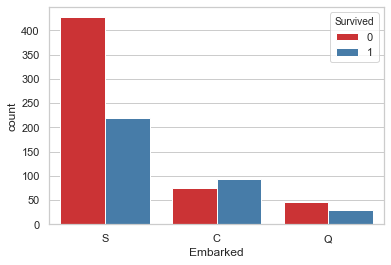

In [48]:
#棒グラフ

sns.countplot(x="Embarked", hue="Survived", palette="Set1", data=df1)

### 2.5 Exploration of Travel alone

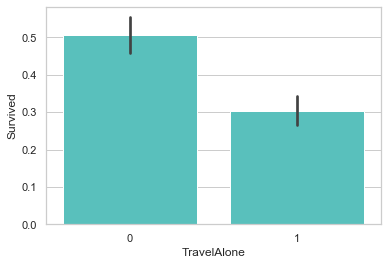

In [49]:
#一人と家族の生存率
#家族がいるほうが生存率が高い

sns.barplot('TravelAlone', 'Survived', data=df2, color="mediumturquoise")
plt.show()

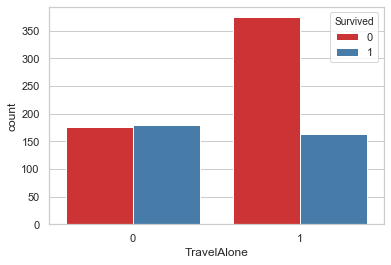

In [50]:
#棒グラフ

sns.countplot(x="TravelAlone", hue="Survived", palette="Set1", data=df1)

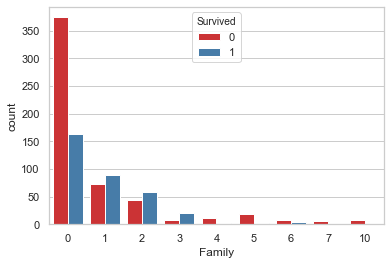

In [51]:
sns.countplot(x="Family", hue="Survived", palette="Set1", data=df1)

### 2.6 Exploration of Gender

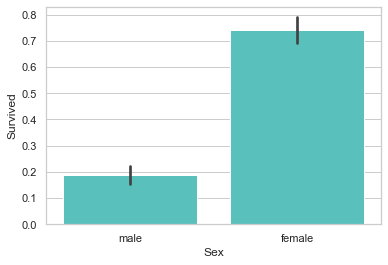

In [52]:
#性別毎の生存率
#女性のほうが生存率が高い

sns.barplot('Sex', 'Survived', data=df1, color="mediumturquoise")
plt.show()

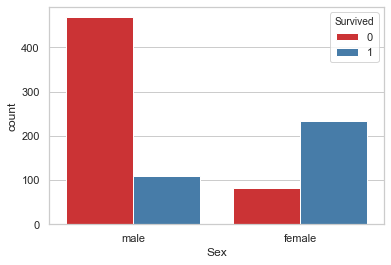

In [53]:
#棒グラフ

sns.countplot(x="Sex", hue="Survived", palette="Set1", data=df1)

## 3. 学習データの作成
### 3.1 特徴量抽出

In [56]:
#特徴量の選択
cols = ["Age","Fare","Family","TravelAlone","Pclass_1","Pclass_2","Embarked_C","Embarked_S","Sex_male","IsMinor"] 
X = df2[cols]
y = df2['Survived']

In [57]:
X.head(5)

,Age,Fare,Family,TravelAlone,Pclass_1,Pclass_2,Embarked_C,Embarked_S,Sex_male,IsMinor
0,22.0,7.2500,1,0,0,0,0,1,1,0
1,38.0,71.2833,1,0,1,0,1,0,0,0
2,26.0,7.9250,0,1,0,0,0,1,0,0
3,35.0,53.1000,1,0,1,0,0,1,0,0
4,35.0,8.0500,0,1,0,0,0,1,1,0


In [58]:
y.head(5)

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

### 3.2 TrainとTestにデータ分割

In [167]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(
X,y,stratify=y,random_state=1)
print(X_train.shape)
print(y_train.shape)
print(np.count_nonzero(y_train==1))
print(np.count_nonzero(y_train==0))
print(np.count_nonzero(y_test==1))
print(np.count_nonzero(y_test==0))

(668, 10)
(668,)
256
412
86
137


## 4. 機械学習
### 4.1 手法の選択

In [168]:
#手法はロジスティック回帰、サポートベクターマシン、k近傍法、決定木を使用する

X.head()

,Age,Fare,Family,TravelAlone,Pclass_1,Pclass_2,Embarked_C,Embarked_S,Sex_male,IsMinor
0,22.0,7.2500,1,0,0,0,0,1,1,0
1,38.0,71.2833,1,0,1,0,1,0,0,0
2,26.0,7.9250,0,1,0,0,0,1,0,0
3,35.0,53.1000,1,0,1,0,0,1,0,0
4,35.0,8.0500,0,1,0,0,0,1,1,0


C:\Users\nakam\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
C:\Users\nakam\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\nakam\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWa

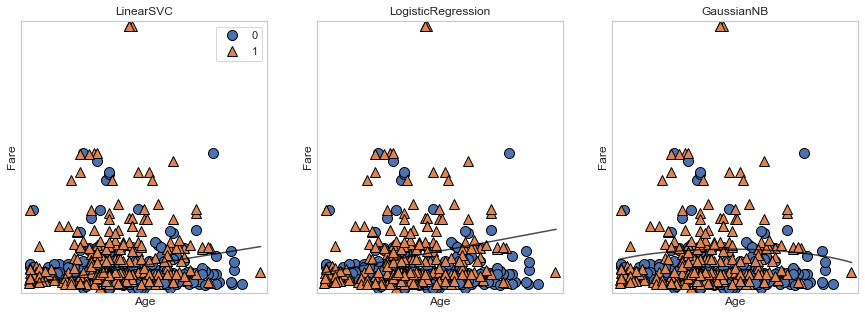

In [61]:
#試しに2次元で機械学習を試行してみる
#2つの特徴量を選択
i=0
j=1

#サポートベクターマシン/ロジスティック回帰/ナイーブベイズクラス分類器

import mglearn
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

fig,axes=plt.subplots(1,3,figsize=(15,5))

for model, ax in zip([LinearSVC(),LogisticRegression(),GaussianNB()],axes):
    clf=model.fit(X.iloc[:,[i,j]],y)
    mglearn.plots.plot_2d_separator(clf,X.iloc[:,[i,j]].values,fill=False,eps=0.5,ax=ax,alpha=0.7)
    mglearn.discrete_scatter(X.iloc[:,i].values,X.iloc[:,j].values,y,ax=ax)
    ax.set_title("{}".format(clf.__class__.__name__))
    ax.set_xlabel(X.columns[i]) #i列目の名前を取得
    ax.set_ylabel(X.columns[j]) #j列目の名前を取得
axes[0].legend()

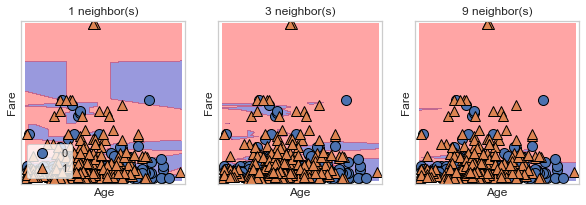

In [62]:
#k近傍法

import mglearn
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier

fig,axes=plt.subplots(1,3,figsize=(10,3))

for n_neighbors,ax in zip([1,3,9],axes): #n_neighborsを調整
    clf=KNeighborsClassifier(n_neighbors=n_neighbors).fit(X.iloc[:,[i,j]].values,y) #学習
    mglearn.plots.plot_2d_separator(clf,X.iloc[:,[i,j]].values,fill=True,eps=0.5,ax=ax,alpha=.4) #plot_2d_separator:境界を作画
    mglearn.discrete_scatter(X.iloc[:,i].values,X.iloc[:,j].values,y,ax=ax) #discrete_scatter:点をプロット
    ax.set_title("{} neighbor(s)".format(n_neighbors))
    ax.set_xlabel(X.columns[i]) #i列目の名前を取得
    ax.set_ylabel(X.columns[j]) #j列目の名前を取得
axes[0].legend(loc=3) #loc=3が左下

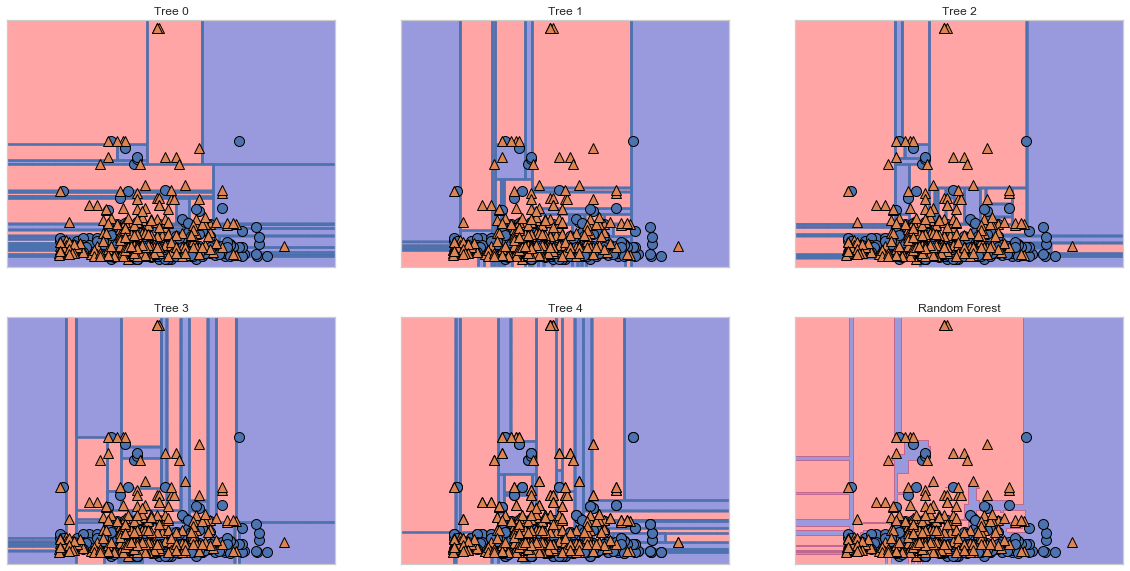

In [63]:
#ランダムフォレスト

from sklearn.ensemble import RandomForestClassifier
forest=RandomForestClassifier(n_estimators=5,random_state=1) #n_estimators:決定木の数
forest.fit(X.iloc[:,[i,j]].values,y)

fig,axes=plt.subplots(2,3,figsize=(20,10))
for n,(ax,tree) in enumerate(zip(axes.ravel(),forest.estimators_)):
    ax.set_title("Tree {}".format(n))
    mglearn.plots.plot_tree_partition(X.iloc[:,[i,j]].values,y,tree,ax=ax)

mglearn.plots.plot_2d_separator(forest,X.iloc[:,[i,j]].values,fill=True,ax=axes[-1,-1],alpha=.4) #axes=最後の行、最後の列を指定
axes[-1,-1].set_title("Random Forest")
mglearn.discrete_scatter(X.iloc[:,i].values,X.iloc[:,j].values,y)

mglearn.discrete_scatter(X.iloc[:,i].values,X.iloc[:,j].values,y,ax=ax) #discrete_scatter:点をプロット

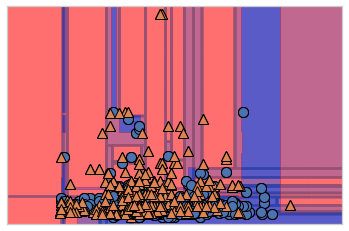

In [64]:
#勾配ブースティング回帰木

from sklearn.ensemble import GradientBoostingClassifier
gbrt=GradientBoostingClassifier(random_state=0) 
gbrt.fit(X.iloc[:,[i,j]].values,y)

mglearn.plots.plot_tree_partition(X.iloc[:,[i,j]].values,y,tree)
mglearn.plots.plot_2d_separator(gbrt,X.iloc[:,[i,j]].values,fill=True,alpha=.4) 
mglearn.discrete_scatter(X.iloc[:,i].values,X.iloc[:,j].values,y)
mglearn.discrete_scatter(X.iloc[:,i].values,X.iloc[:,j].values,y) #discrete_scatter:点をプロット

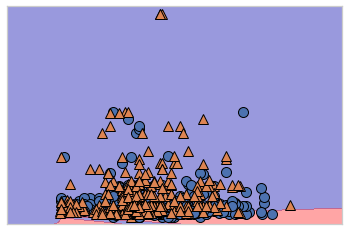

In [67]:
#ディープラーニング

from sklearn.neural_network import MLPClassifier

mlp=MLPClassifier(solver='lbfgs',random_state=0)
mlp.fit(X.iloc[:,[i,j]].values,y)

mglearn.plots.plot_2d_separator(mlp,X.iloc[:,[i,j]].values,fill=True,alpha=.4) 
mglearn.discrete_scatter(X.iloc[:,i].values,X.iloc[:,j].values,y)

### 4.2 機械学習:ロジスティック回帰分析
#### 4.2.1 L2正則化

In [68]:
#まずは学習

from sklearn.linear_model import LogisticRegression

logreg=LogisticRegression().fit(X_train,y_train)
print("Training set score: {:.3f}".format(logreg.score(X_train,y_train)))
print("Test set score: {:.3f}".format(logreg.score(X_test,y_test)))

Training set score: 0.813
Test set score: 0.807


C:\Users\nakam\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


C:\Users\nakam\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\nakam\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\nakam\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\nakam\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\nakam\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

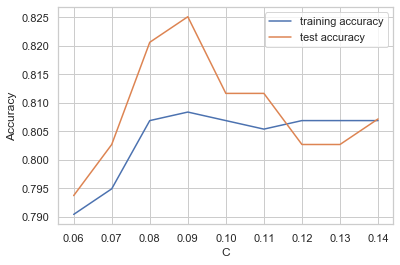

In [69]:
#L2正則化でモデル調整

training_accuracy=[] #訓練の精度
test_accuracy=[] #テストの精度

#cを調整
c_settings=[i / 100 for i in range(6, 15, 1)]
for c in c_settings:
    #モデルを構築
    logreg=LogisticRegression(C=c)
    logreg.fit(X_train,y_train)
    #訓練セット精度を記録
    training_accuracy.append(logreg.score(X_train,y_train))
    #凡化性能を記録
    test_accuracy.append(logreg.score(X_test,y_test))
        
plt.plot(c_settings, training_accuracy, label="training accuracy")
plt.plot(c_settings, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("C")
plt.legend()

In [71]:
#c=0.08が最適となったので、全データを学習

logreg=LogisticRegression(C=0.08).fit(X,y)
print("Training set score: {:.3f}".format(logreg.score(X,y)))

Training set score: 0.805


C:\Users\nakam\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


#### 4.2.2 L1正則化

C:\Users\nakam\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\nakam\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\nakam\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\nakam\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\nakam\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

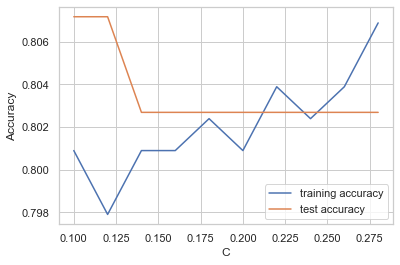

In [72]:
#L1正則化でモデル調整

training_accuracy=[] #訓練の精度
test_accuracy=[] #テストの精度

#cを調整
c_settings=[i / 100 for i in range(10, 30, 2)]
for c in c_settings:
    #モデルを構築
    logregl1=LogisticRegression(C=c,penalty='l1')
    logregl1.fit(X_train,y_train)
    #訓練セット精度を記録
    training_accuracy.append(logregl1.score(X_train,y_train))
    #凡化性能を記録
    test_accuracy.append(logregl1.score(X_test,y_test))
        
plt.plot(c_settings, training_accuracy, label="training accuracy")
plt.plot(c_settings, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("C")
plt.legend()

In [73]:
#c=0.25が最適となったので、全データを学習

logregl1=LogisticRegression(C=0.25,penalty='l1').fit(X,y)
print("Training set score: {:.3f}".format(logreg.score(X,y)))

Training set score: 0.805


C:\Users\nakam\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


#### 4.2.3 ロジスティック回帰結果

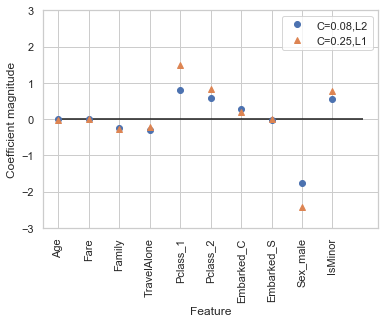

In [74]:
#男であれば生存率が下がる
#クラスが高いほど生存率が上がる
#16歳未満は生存率が上がる

plt.plot(logreg.coef_.T,'o',label='C=0.08,L2')
plt.plot(logregl1.coef_.T,'^',label='C=0.25,L1')
plt.xticks(range(X.shape[1]),X.columns,rotation=90)
plt.hlines(0,0,X.shape[1])
plt.ylim(-3,3)
plt.xlabel("Feature")
plt.ylabel("Coefficient magnitude")
plt.legend()

### 4.3 サポートベクターマシン
#### 4.3.1 L2正則化

In [75]:
#まずは学習

from sklearn.svm import LinearSVC
SVM=LinearSVC().fit(X_train,y_train)
print("Training set score: {:.3f}".format(SVM.score(X_train,y_train)))
print("Test set score: {:.3f}".format(SVM.score(X_test,y_test)))

Training set score: 0.626
Test set score: 0.614


C:\Users\nakam\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


C:\Users\nakam\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\nakam\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\nakam\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\nakam\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\nakam\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

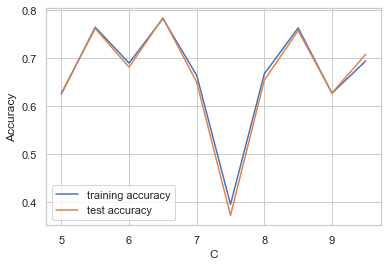

In [76]:
#L2正則化でモデル調整

training_accuracy=[] #訓練の精度
test_accuracy=[] #テストの精度

#cを調整
c_settings=[i / 100 for i in range(500, 1000, 50)]
for c in c_settings:
    #モデルを構築
    SVM=LinearSVC(C=c)
    SVM.fit(X_train,y_train)
    #訓練セット精度を記録
    training_accuracy.append(SVM.score(X_train,y_train))
    #凡化性能を記録
    test_accuracy.append(SVM.score(X_test,y_test))
        
plt.plot(c_settings, training_accuracy, label="training accuracy")
plt.plot(c_settings, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("C")
plt.legend()

In [94]:
#c=6.5が最適となったので、全データを学習

SVM=LinearSVC(C=6.5).fit(X,y)
print("Training set score: {:.3f}".format(SVM.score(X,y)))

Training set score: 0.806


C:\Users\nakam\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [300]:
#カーネル法を用いたサポートベクタ

from sklearn.svm import SVC

#訓練セットの特徴量毎に最小値を計算
min_on_training=X_train.min(axis=0)

#訓練セットの特徴量毎にレンジ(最大-最小)を計算
range_on_training=(X_train-min_on_training).max(axis=0)

#最小値を引いてレンジで割る
#個々の特徴量はmin=0,max=1
X_train_scaled_svm=(X_train-min_on_training)/range_on_training
print("Minimum for each feature\n{}".format(X_train_scaled_svm.min(axis=0)))

print("Maximum for each feature\n{}".format(X_train_scaled_svm.max(axis=0)))

Minimum for each feature
Age            0.0
Fare           0.0
Family         0.0
TravelAlone    0.0
Pclass_1       0.0
Pclass_2       0.0
Embarked_C     0.0
Embarked_S     0.0
Sex_male       0.0
IsMinor        0.0
dtype: float64
Maximum for each feature
Age            1.0
Fare           1.0
Family         1.0
TravelAlone    1.0
Pclass_1       1.0
Pclass_2       1.0
Embarked_C     1.0
Embarked_S     1.0
Sex_male       1.0
IsMinor        1.0
dtype: float64


In [301]:
X_test_scaled_svm=(X_test-min_on_training)/range_on_training #テストデータも変換

svc=SVC()
svc.fit(X_train_scaled_svm,y_train)

print("Accuracy on training set: {:.3f}".format(svc.score(X_train_scaled_svm,y_train)))
print("Accuracy on test set: {:.3f}".format(svc.score(X_test_scaled_svm,y_test)))

Accuracy on training set: 0.786
Accuracy on test set: 0.803


C:\Users\nakam\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [302]:
#全データを学習
X_scaled_svm=(X-min_on_training)/range_on_training #テストデータも変換
svc.fit(X_scaled_svm,y)
print("Training set score: {:.3f}".format(svc.score(X_scaled_svm,y)))

Training set score: 0.790


C:\Users\nakam\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


### 4.4 k近傍法

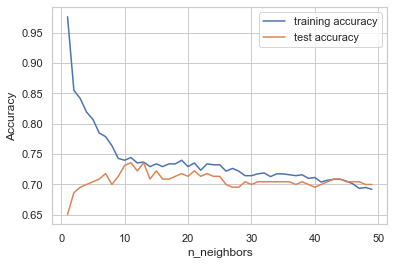

In [95]:
#パラメータ変更の影響検証

%matplotlib inline
import matplotlib.pyplot as plt

training_accuracy=[] #訓練の精度
test_accuracy=[] #テストの精度

#n_neighborsを調整する
neighbors_settings=range(1,50)
for n_neighbors in neighbors_settings:
    #モデルを構築
    clf=KNeighborsClassifier(n_neighbors=n_neighbors)
    clf.fit(X_train,y_train)
    #訓練セット精度を記録
    training_accuracy.append(clf.score(X_train,y_train))
    #凡化性能を記録
    test_accuracy.append(clf.score(X_test,y_test))
        
plt.plot(neighbors_settings, training_accuracy, label="training accuracy")
plt.plot(neighbors_settings, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()

In [96]:
#k=10が最適となったので、全データを学習

clf=KNeighborsClassifier(n_neighbors=10).fit(X,y)
print("Training set score: {:.3f}".format(clf.score(X,y)))

Training set score: 0.762


### 4.5 ナイーブベイズクラス分類器

In [97]:
#性能確認
clf_NB=GaussianNB().fit(X_train,y_train)
print("Training set score: {:.3f}".format(clf_NB.score(X_test,y_test)))

Training set score: 0.785


In [98]:
#学習
clf_NB=GaussianNB().fit(X,y)
print("Training set score: {:.3f}".format(clf_NB.score(X,y)))

Training set score: 0.781


### 4.6 決定木

In [260]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

tree=DecisionTreeClassifier(random_state=0)
tree.fit(X_train,y_train)
print("Accuracy on training set: {:.3f}".format(tree.score(X_train,y_train)))
print("Accuracy on test set: {:3f}".format(tree.score(X_test,y_test)))

Accuracy on training set: 0.984
Accuracy on test set: 0.798206


In [261]:
#過剰適合しているため、木の深さを4で止めるよう設定

tree=DecisionTreeClassifier(max_depth=4,random_state=0)
tree.fit(X_train,y_train)
print("Accuracy on training set: {:.3f}".format(tree.score(X_train,y_train)))
print("Accuracy on test set: {:3f}".format(tree.score(X_test,y_test)))

Accuracy on training set: 0.825
Accuracy on test set: 0.834081


In [262]:
#問題ないため全データを学習

tree=DecisionTreeClassifier(max_depth=4,random_state=0)
tree.fit(X,y)
print("Accuracy on training set: {:.3f}".format(tree.score(X,y)))

Accuracy on training set: 0.827


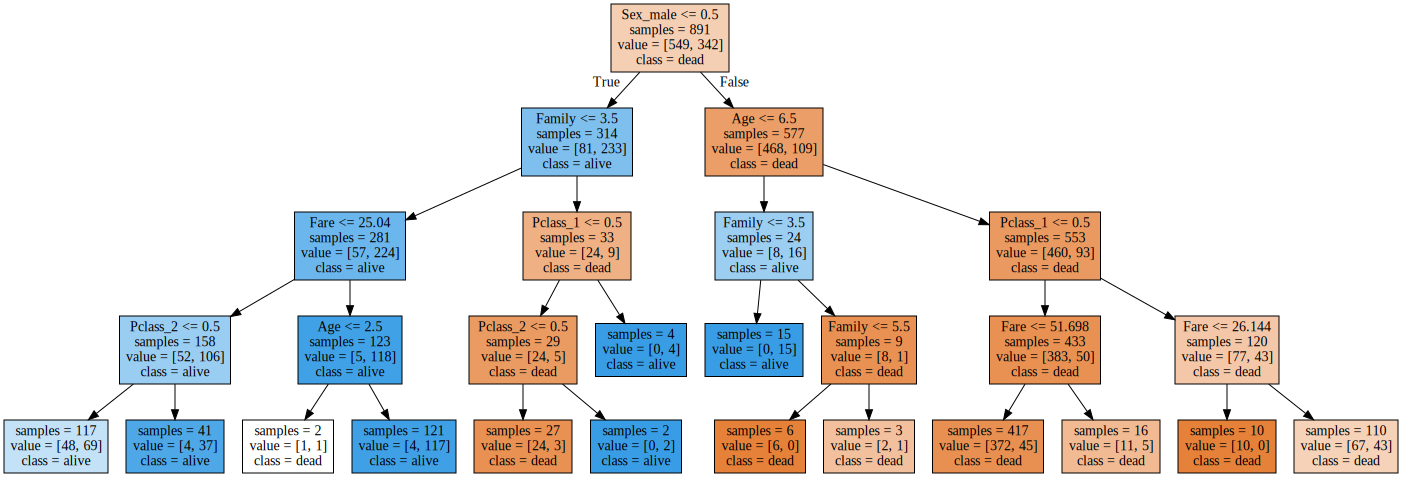

In [263]:
#クライテリアを描画

import os
folder="C:\\Users\\nakam\\Python\\Data\\kaggle"
os.chdir(folder)

from sklearn.tree import export_graphviz
export_graphviz(tree,out_file="tree.dot",class_names=["dead","alive"],
               feature_names=X.columns,impurity=False, filled=True)

import graphviz

with open("tree.dot") as f:
    dot_graph=f.read()
graphviz.Source(dot_graph)

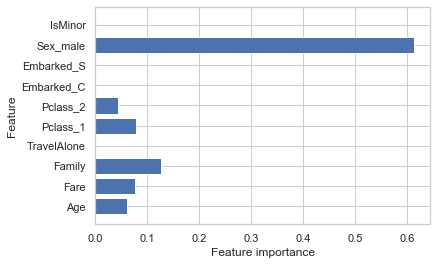

In [264]:
#特徴量の重要度をグラフ化

import matplotlib.pyplot as plt
import numpy as np

def plot_feature_importances(model):
    n_features=len(X.columns) #特徴量の数を格納
    plt.barh(range(n_features),model.feature_importances_,align='center')
    plt.yticks(np.arange(n_features),X.columns) #np.arangeで0-n_featuresの配列を作成する
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    
plot_feature_importances(tree)

### 4.7 ランダムフォレスト

In [265]:
from sklearn.ensemble import RandomForestClassifier
forest=RandomForestClassifier(n_estimators=1000,max_depth=9,random_state=42) #n_estimators:決定木の数
forest.fit(X_train,y_train)

print("Accuracy on training set: {:.3f}".format(forest.score(X_train,y_train)))
print("Accuracy on test set: {:3f}".format(forest.score(X_test,y_test)))

Accuracy on training set: 0.949
Accuracy on test set: 0.816143


In [266]:
#問題ないため全データを学習

forest=RandomForestClassifier(n_estimators=1000,max_depth=9,random_state=42)
forest.fit(X,y)
print("Accuracy on training set: {:.3f}".format(forest.score(X,y)))

Accuracy on training set: 0.933


In [267]:
#クライテリアを描画

import os
folder="C:\\Users\\nakam\\Python\\Data\\kaggle"
os.chdir(folder)

from sklearn.tree import export_graphviz
for i,val in enumerate(forest.estimators_):
    export_graphviz(forest.estimators_[i], out_file="forest.dot",class_names=["dead","alive"],
                    feature_names=X.columns,impurity=False, filled=True)

import graphviz
with open("forest.dot") as f:
    dot_graph=f.read()
graph = graphviz.Source(dot_graph)
graph.render("random_forest", format="png")

'random_forest.png'

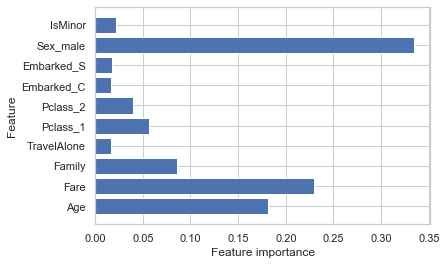

In [268]:
#特徴量の重要度をグラフ化

import matplotlib.pyplot as plt
import numpy as np

def plot_feature_importances(model):
    n_features=len(X.columns) #特徴量の数を格納
    plt.barh(range(n_features),model.feature_importances_,align='center')
    plt.yticks(np.arange(n_features),X.columns) #np.arangeで0-n_featuresの配列を作成する
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    
plot_feature_importances(forest)

### 4.8 勾配ブースティング回帰木

In [269]:
from sklearn.ensemble import GradientBoostingClassifier

gbrt=GradientBoostingClassifier(random_state=0)
gbrt.fit(X_train,y_train)

print("Accuracy on training set: {:.3f}".format(gbrt.score(X_train,y_train)))
print("Accuracy on test set: {:3f}".format(gbrt.score(X_test,y_test)))

Accuracy on training set: 0.904
Accuracy on test set: 0.820628


In [270]:
#max_depthを制御
from sklearn.ensemble import GradientBoostingClassifier

gbrt1=GradientBoostingClassifier(random_state=0,max_depth=1,n_estimators=500)
gbrt1.fit(X_train,y_train)

print("Accuracy on training set: {:.3f}".format(gbrt1.score(X_train,y_train)))
print("Accuracy on test set: {:3f}".format(gbrt1.score(X_test,y_test)))

Accuracy on training set: 0.838
Accuracy on test set: 0.802691


In [271]:
#0番目の決定木のクライテリアを描画

import os
folder="C:\\Users\\nakam\\Python\\Data\\kaggle"
os.chdir(folder)

from sklearn.tree import export_graphviz
export_graphviz(gbrt1.estimators_[0,0],out_file="gbrt.dot",class_names=["dead","alive"],
               feature_names=X.columns,impurity=False, filled=True) #[n,0]でn番目の決定木

import graphviz
with open("gbrt.dot") as f:
    dot_graph=f.read()
graph = graphviz.Source(dot_graph)
graph.render("gbrt", format="png")

'gbrt.png'

In [272]:
#全データを学習
gbrt1=GradientBoostingClassifier(random_state=0,max_depth=1,n_estimators=500)
gbrt1.fit(X,y)

print("Accuracy on training set: {:.3f}".format(gbrt1.score(X,y)))

Accuracy on training set: 0.833


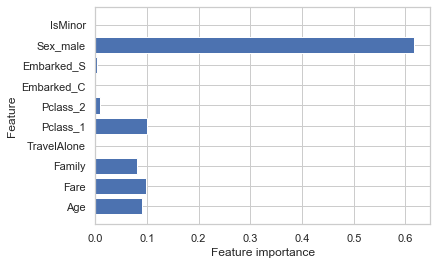

In [273]:
#特徴量の重要度をグラフ化

import matplotlib.pyplot as plt
import numpy as np

def plot_feature_importances(model):
    n_features=len(X.columns) #特徴量の数を格納
    plt.barh(range(n_features),model.feature_importances_,align='center')
    plt.yticks(np.arange(n_features),X.columns) #np.arangeで0-n_featuresの配列を作成する
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    
plot_feature_importances(gbrt1)

In [274]:
#学習率を制御
from sklearn.ensemble import GradientBoostingClassifier

gbrt2=GradientBoostingClassifier(random_state=0,learning_rate=0.01,n_estimators=500)
gbrt2.fit(X_train,y_train)

print("Accuracy on training set: {:.3f}".format(gbrt2.score(X_train,y_train)))
print("Accuracy on test set: {:3f}".format(gbrt2.score(X_test,y_test)))

Accuracy on training set: 0.865
Accuracy on test set: 0.820628


In [275]:
#全データを学習
gbrt2=GradientBoostingClassifier(random_state=0,learning_rate=0.01,n_estimators=500)
gbrt2.fit(X,y)

print("Accuracy on training set: {:.3f}".format(gbrt2.score(X,y)))

Accuracy on training set: 0.859


### 4.9 ディープラーニング

In [218]:
from sklearn.neural_network import MLPClassifier

mlp=MLPClassifier(max_iter=1000,random_state=42)
mlp.fit(X_train,y_train)

print("Accuracy on training set: {:.3f}".format(mlp.score(X_train,y_train)))
print("Accuracy on test set: {:3f}".format(mlp.score(X_test,y_test)))

Accuracy on training set: 0.831
Accuracy on test set: 0.816143


In [219]:
#平均0、分散1が好ましいのでスケール変換を実施する
mean_on_train=X_train.mean(axis=0)
std_on_train=X_train.std(axis=0)

#平均を引き、標準偏差の逆数でスケール変換
X_train_scaled=(X_train-mean_on_train)/std_on_train
X_test_scaled=(X_test-mean_on_train)/std_on_train

mlp=MLPClassifier(random_state=42)
mlp.fit(X_train_scaled,y_train)

print("Accuracy on training set: {:.3f}".format(mlp.score(X_train_scaled,y_train)))
print("Accuracy on test set: {:.3f}".format(mlp.score(X_test_scaled,y_test)))

Accuracy on training set: 0.840
Accuracy on test set: 0.830


C:\Users\nakam\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


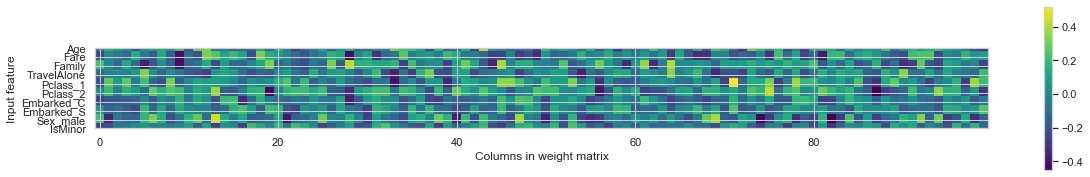

In [220]:
#学習結果を表示
plt.figure(figsize=(20,3))
plt.imshow(mlp.coefs_[0],interpolation='none',cmap='viridis')
plt.yticks(range(10),X.columns) #特徴量が30個ある
plt.xlabel("Columns in weight matrix")
plt.ylabel("Input feature")
plt.colorbar()

In [221]:
#reluで調整
mlp_relu_100_100=MLPClassifier(max_iter=1000,random_state=42,hidden_layer_sizes=[100,100],alpha=0.5)
mlp_relu_100_100.fit(X_train_scaled,y_train)

print("Accuracy on training set: {:.3f}".format(mlp_relu_100_100.score(X_train_scaled,y_train)))
print("Accuracy on test set: {:.3f}".format(mlp_relu_100_100.score(X_test_scaled,y_test)))

Accuracy on training set: 0.849
Accuracy on test set: 0.834


In [222]:
#平均0、分散1が好ましいのでスケール変換を実施する
mean_on_train=X.mean(axis=0)
std_on_train=X.std(axis=0)

#平均を引き、標準偏差の逆数でスケール変換
X_scaled=(X-mean_on_train)/std_on_train

#全データを学習
mlp_relu_100_100.fit(X_scaled,y)

print("Accuracy on training set: {:.3f}".format(mlp_relu_100_100.score(X_scaled,y)))

Accuracy on training set: 0.859


In [223]:
#tanhで調整
mlp_tanh_100_100=MLPClassifier(max_iter=1000,random_state=42,hidden_layer_sizes=[100,100],alpha=0.2,activation='tanh')
mlp_tanh_100_100.fit(X_train_scaled,y_train)

print("Accuracy on training set: {:.3f}".format(mlp_tanh_100_100.score(X_train_scaled,y_train)))
print("Accuracy on test set: {:.3f}".format(mlp_tanh_100_100.score(X_test_scaled,y_test)))

Accuracy on training set: 0.849
Accuracy on test set: 0.830


In [224]:
#全データを学習
mlp_tanh_100_100.fit(X_scaled,y)

print("Accuracy on training set: {:.3f}".format(mlp_tanh_100_100.score(X_scaled,y)))

Accuracy on training set: 0.844


In [225]:
#relu1層で調整
mlp_relu_100=MLPClassifier(max_iter=1000,random_state=42,hidden_layer_sizes=100,alpha=0.6)
mlp_relu_100.fit(X_train_scaled,y_train)

print("Accuracy on training set: {:.3f}".format(mlp_relu_100.score(X_train_scaled,y_train)))
print("Accuracy on test set: {:.3f}".format(mlp_relu_100.score(X_test_scaled,y_test)))

Accuracy on training set: 0.843
Accuracy on test set: 0.830


In [226]:
#全データを学習
mlp_relu_100.fit(X_scaled,y)

print("Accuracy on training set: {:.3f}".format(mlp_relu_100.score(X_scaled,y)))

Accuracy on training set: 0.838


In [227]:
#tanh1層で調整
mlp_tanh_100=MLPClassifier(max_iter=1000,random_state=42,hidden_layer_sizes=100,activation='tanh',alpha=0.2)
mlp_tanh_100.fit(X_train_scaled,y_train)

print("Accuracy on training set: {:.3f}".format(mlp_tanh_100.score(X_train_scaled,y_train)))
print("Accuracy on test set: {:.3f}".format(mlp_tanh_100.score(X_test_scaled,y_test)))

Accuracy on training set: 0.837
Accuracy on test set: 0.812


In [228]:
#全データを学習
mlp_tanh_100.fit(X_scaled,y)

print("Accuracy on training set: {:.3f}".format(mlp_tanh_100.score(X_scaled,y)))

Accuracy on training set: 0.837


## 5. 結果出力
### 5.1 Testデータ読み込み

In [276]:
#testデータ読み込み
df_test=pd.read_csv('test.csv')
df_test.head()

#欠損値確認
df_test.isnull().sum() #欠損値確認

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

### 5.2 Testデータの前処理

In [277]:
#Trainデータと同様の処理を行う

test_data = df_test.copy()
test_data["Age"].fillna(df["Age"].median(skipna=True), inplace=True)
test_data["Fare"].fillna(df["Fare"].median(skipna=True), inplace=True)
test_data.drop('Cabin', axis=1, inplace=True)

test_data['TravelAlone']=np.where((test_data["SibSp"]+test_data["Parch"])>0, 0, 1)
test_data['Family']=test_data['SibSp']+test_data['Parch']
test_data.drop('SibSp', axis=1, inplace=True)
test_data.drop('Parch', axis=1, inplace=True)

testing = pd.get_dummies(test_data, columns=["Pclass","Embarked","Sex"])
testing.drop('Sex_female', axis=1, inplace=True)
testing.drop('PassengerId', axis=1, inplace=True)
testing.drop('Name', axis=1, inplace=True)
testing.drop('Ticket', axis=1, inplace=True)

final_test = testing

final_test['IsMinor']=np.where(final_test['Age']<=16, 1, 0)
final_test.head()

,Age,Fare,TravelAlone,Family,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Sex_male,IsMinor
0,34.5,7.8292,1,0,0,0,1,0,1,0,1,0
1,47.0,7.0000,0,1,0,0,1,0,0,1,0,0
2,62.0,9.6875,1,0,0,1,0,0,1,0,1,0
3,27.0,8.6625,1,0,0,0,1,0,0,1,1,0
4,22.0,12.2875,0,2,0,0,1,0,0,1,0,0


In [278]:
#特徴量抽出

cols = ["Age","Fare","Family","TravelAlone","Pclass_1","Pclass_2","Embarked_C","Embarked_S","Sex_male","IsMinor"] 
X_final_test = final_test[cols]

### 5.3 結果出力
#### 5.3.1 ロジスティック回帰：L2正則化結果出力

In [122]:
print("Test set predictions: {}".format(logreg.predict(X_final_test))) #テスト
output=logreg.predict(X_final_test)

Test set predictions: [0 0 0 0 0 0 1 0 1 0 0 0 1 0 1 1 0 0 1 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 1
 1 0 0 0 0 0 1 1 0 0 0 1 0 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 1 1 0 1 0
 1 1 0 1 0 1 0 1 0 0 0 0 1 1 1 0 1 0 1 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 1 1 0 0 1 0 1 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0
 0 0 1 0 0 0 0 0 1 1 0 0 1 0 1 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 1 1 0 0 1 0 1
 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0 1 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0
 1 0 1 1 0 1 0 0 1 1 0 0 0 0 0 0 1 1 1 1 1 0 0 0 1 0 1 1 1 0 1 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 1 0 0 0 0
 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0
 1 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 1 0 1 0 0 1 0 1 1 0 1 0 0 1 1 0
 0 1 0 0 1 1 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 1 0 0 0 0
 1 1 1 1 1 1 0 1 0 0 0]


In [123]:
#データ出力

import csv
with open("predict_result_data_rogistic_l2.csv", "w") as f:
    writer = csv.writer(f, lineterminator='\n')
    writer.writerow(["PassengerId", "Survived"])
    for pid, survived in zip(df_test["PassengerId"].astype(int), output.astype(int)):
        writer.writerow([pid, survived])

#### 5.3.2  ロジスティック回帰：L1正則化結果出力

In [124]:
print("Test set predictions: {}".format(logregl1.predict(X_final_test))) #テスト
output=logregl1.predict(X_final_test)

Test set predictions: [0 0 0 0 1 0 1 0 1 0 0 0 1 0 1 1 0 0 1 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 1
 1 0 0 0 0 0 1 1 0 0 0 1 0 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 1 1 0 1 0
 1 1 0 1 0 1 0 0 0 0 0 0 1 1 1 0 1 0 1 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 1 1 0 0 1 0 1 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 1 1 0 1 1 0 1 0 0 1 0 0 1 1 0 0 0 0 0 1 1 0 1 1 0 0 1 0 1
 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0 1 1 0 0 1 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0
 1 0 1 1 0 1 0 0 1 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 0 1 1 1 0 1 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 1 0 0 0 0
 1 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0
 1 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 1 0 1 0 0 1 0 1 1 0 1 0 0 1 1 0
 0 1 0 0 1 1 1 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 1 0 0 0 0
 0 1 1 1 1 1 0 1 0 0 0]


In [125]:
import csv
with open("predict_result_data_rogistic_l1.csv", "w") as f:
    writer = csv.writer(f, lineterminator='\n')
    writer.writerow(["PassengerId", "Survived"])
    for pid, survived in zip(df_test["PassengerId"].astype(int), output.astype(int)):
        writer.writerow([pid, survived])

#### 5.3.3  SVM : L2正則化結果出力

In [126]:
print("Test set predictions: {}".format(SVM.predict(X_final_test))) #テスト
output=SVM.predict(X_final_test)

Test set predictions: [0 0 0 0 1 0 1 0 1 0 0 0 1 0 1 1 0 0 1 0 1 0 1 1 1 0 1 0 0 0 0 0 0 0 1 0 0
 1 0 0 0 0 0 1 1 0 0 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 1 1 1 0 0 1
 1 1 0 1 0 1 1 1 0 0 0 0 1 1 1 1 1 0 1 0 1 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 1 1 0 0 1 1 1 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 1 1 0 1 1 1 1 0 0 1 0 0 1 1 0 0 0 0 0 1 1 1 1 1 0 1 1 0 1
 0 1 0 0 0 0 0 0 0 1 0 1 1 0 0 1 0 1 1 0 1 1 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0
 1 0 1 1 0 1 0 0 1 1 0 0 1 0 0 0 1 1 1 1 1 0 0 1 1 0 1 1 1 0 1 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 1 0 1 1 1 0 0 1 0 0 0 1 0 0 0 0
 1 0 0 0 0 0 0 0 1 1 1 1 0 1 0 0 0 1 1 1 1 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0
 1 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 1 0 1 0 0 1 0 1 1 0 1 0 0 1 1 0
 0 1 0 0 1 1 1 0 0 0 0 0 0 1 0 1 0 0 0 0 1 1 0 0 0 1 0 1 0 0 1 0 1 1 1 0 0
 1 1 1 1 1 0 0 1 0 0 0]


In [127]:
with open("predict_result_data_SVM_l2.csv", "w") as f:
    writer = csv.writer(f, lineterminator='\n')
    writer.writerow(["PassengerId", "Survived"])
    for pid, survived in zip(df_test["PassengerId"].astype(int), output.astype(int)):
        writer.writerow([pid, survived])

In [303]:
X_final_scaled_svm=(X_final_test-min_on_training)/range_on_training #変換

print("Test set predictions: {}".format(svc.predict(X_final_scaled_svm)))
output=svc.predict(X_final_scaled_svm)

Test set predictions: [0 1 0 0 1 0 1 0 1 0 0 0 1 0 1 1 0 0 1 1 0 0 1 0 1 0 1 0 0 0 0 0 1 1 0 0 1
 1 0 0 0 0 0 1 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 1 0 1 1 0 0 1 1 0 1 0
 1 0 0 1 0 1 0 0 0 0 0 0 1 1 1 0 1 0 1 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 1 1 0 0 1 0 1 1 0 1 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0
 0 0 1 0 0 1 0 0 1 1 0 1 1 0 1 0 0 1 0 0 1 1 0 0 0 0 0 1 1 0 1 1 0 0 1 0 1
 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 1 0 0 1 0 1 0 0 0 0 1 1 0 1 0 1 0 1 0
 1 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 1 0 0 0 0
 1 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0
 1 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 1 0 1 0 0 1 0 1 1 0 1 0 0 1 1 0
 0 1 0 0 1 1 1 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 1 0 0 0 0
 0 1 1 1 1 1 0 1 0 0 0]


In [304]:
with open("predict_result_data_SVC_kernel.csv", "w") as f:
    writer = csv.writer(f, lineterminator='\n')
    writer.writerow(["PassengerId", "Survived"])
    for pid, survived in zip(df_test["PassengerId"].astype(int), output.astype(int)):
        writer.writerow([pid, survived])

#### 5.3.4  k近傍法結果出力

In [128]:
print("Test set predictions: {}".format(clf.predict(X_final_test))) #テスト
output=clf.predict(X_final_test)

Test set predictions: [0 0 0 0 0 0 0 1 0 1 0 0 1 0 1 1 0 0 0 0 0 1 1 1 1 0 1 0 0 0 0 1 0 0 1 0 0
 0 0 1 0 0 0 1 1 0 0 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0
 1 1 0 0 0 0 1 1 1 0 0 0 1 0 1 1 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 1 1 0 1 0 0 1 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0
 0 0 1 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 1
 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 1 0 0 0
 0 0 0 1 0 1 0 0 1 1 0 0 1 0 1 0 0 1 0 0 1 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0
 0 0 0 1 1 1 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 1 1 1 1 0 0 1 0 0 0 0 0 1 0 0
 1 0 0 0 0 0 0 0 1 0 1 1 1 0 0 0 0 0 1 0 1 0 0 1 0 0 0 1 1 0 0 1 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0
 0 1 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 1 0 1 0 0 1 0 1 0 0 0 0
 1 1 1 1 1 0 0 1 0 0 1]


In [129]:
with open("predict_result_data_clf.csv", "w") as f:
    writer = csv.writer(f, lineterminator='\n')
    writer.writerow(["PassengerId", "Survived"])
    for pid, survived in zip(df_test["PassengerId"].astype(int), output.astype(int)):
        writer.writerow([pid, survived])

#### 5.3.5  ナイーブベイズクラス分類器結果出力

In [130]:
print("Test set predictions: {}".format(clf_NB.predict(X_final_test))) #テスト
output=clf.predict(X_final_test)

Test set predictions: [0 1 0 0 1 0 1 0 1 0 0 0 1 0 1 1 0 0 1 1 1 1 1 1 1 0 1 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 1 1 1 0 0 1
 1 1 0 1 0 1 1 1 0 0 0 0 1 0 1 1 1 0 1 0 1 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 1 1 0 0 1 1 1 1 0 1 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0
 0 0 1 0 0 0 0 0 1 0 0 1 1 1 1 0 0 1 1 0 1 0 0 0 0 0 0 1 1 1 1 1 0 1 1 0 1
 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 1 1 1 1 0 1 1 0 1 0 0 0 0 1 0 0 1 1 1 0 1 0
 1 0 1 1 0 1 0 0 1 1 0 0 1 0 1 0 1 1 1 1 1 0 0 0 1 0 1 1 1 0 1 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 0 0 1 0 1 1 0 1 0 0 0 0 0 1 1 1 1 0 0 1 0 0 0 1 0 1 0 0
 1 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 1 1 1 1 0 0 0 0 0 0 0 1 0 1 1 0 0 1 1 0
 1 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 1 0 0 0 1 0 1 0 0 1 0 1 0 0 1 0 0 0 1 0
 0 1 0 0 1 1 1 0 0 0 0 0 0 1 0 1 0 0 0 0 1 1 0 0 0 1 0 1 0 0 1 0 1 0 1 0 0
 1 1 1 1 1 0 0 1 0 0 0]


In [131]:
with open("predict_result_data_clf_NB.csv", "w") as f:
    writer = csv.writer(f, lineterminator='\n')
    writer.writerow(["PassengerId", "Survived"])
    for pid, survived in zip(df_test["PassengerId"].astype(int), output.astype(int)):
        writer.writerow([pid, survived])

#### 5.3.6 決定木結果出力

In [279]:
print("Test set predictions: {}".format(tree.predict(X_final_test))) #テスト
output=tree.predict(X_final_test)

Test set predictions: [0 1 0 0 1 0 1 0 1 0 0 0 1 0 1 1 0 0 1 1 0 0 1 0 1 0 1 0 0 0 0 0 1 1 0 0 1
 1 0 0 0 0 0 1 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 1 0 1 1 0 0 1 1 0 1 0
 1 0 0 1 0 1 1 0 0 0 0 0 1 1 1 1 1 0 1 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 1 1 0 0 1 0 1 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0
 0 0 1 0 0 1 0 0 1 1 0 1 1 0 1 0 0 1 0 0 1 1 0 0 0 0 0 1 1 0 1 1 0 0 1 0 1
 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 1 1 0 1 0 0 1 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0
 1 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 0 1 0 1 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0
 1 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 1 0 1 0 0 1 0 1 1 0 1 0 0 1 1 0
 0 1 0 0 1 1 1 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 1 0 0 0 0
 0 1 1 1 1 1 0 1 0 0 0]


In [280]:
with open("predict_result_data_tree.csv", "w") as f:
    writer = csv.writer(f, lineterminator='\n')
    writer.writerow(["PassengerId", "Survived"])
    for pid, survived in zip(df_test["PassengerId"].astype(int), output.astype(int)):
        writer.writerow([pid, survived])

#### 5.3.7 ランダムフォレスト結果出力

In [281]:
print("Test set predictions: {}".format(forest.predict(X_final_test))) #テスト
output=tree.predict(X_final_test)

Test set predictions: [0 0 0 0 1 0 0 0 1 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 1 0 1 0 1 0 0 0 1 0 1 0 0
 0 0 0 0 1 0 1 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 1 1 0 0 0
 1 0 0 1 0 1 1 0 0 0 0 0 1 0 1 1 1 0 1 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 1 1 0 0 1 0 1 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0
 1 0 1 0 0 1 0 0 1 1 1 1 1 1 1 0 0 1 0 0 1 0 0 0 0 0 0 1 1 0 1 1 0 0 1 0 1
 0 1 0 0 0 0 0 1 0 1 0 1 0 0 0 1 1 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0
 1 0 1 0 0 1 0 0 0 1 0 0 1 0 0 0 1 1 1 1 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 1 0 0
 1 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 1 0 1 0 0 1 0 1 1 0 1 0 0 1 1 0
 0 1 0 0 1 1 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 1 0 0 0 0
 0 1 1 1 1 0 0 1 0 0 0]


In [282]:
with open("predict_result_data_forest.csv", "w") as f:
    writer = csv.writer(f, lineterminator='\n')
    writer.writerow(["PassengerId", "Survived"])
    for pid, survived in zip(df_test["PassengerId"].astype(int), output.astype(int)):
        writer.writerow([pid, survived])

#### 5.3.8 勾配ブースティング回帰木

In [283]:
print("Test set predictions: {}".format(gbrt1.predict(X_final_test))) #テスト
output=gbrt1.predict(X_final_test)

Test set predictions: [0 0 0 0 1 0 1 0 1 0 0 0 1 0 1 1 0 0 1 1 1 0 1 1 1 0 1 0 0 0 0 0 1 1 1 0 1
 1 0 0 0 0 0 1 1 0 0 0 1 1 1 0 1 1 0 0 0 0 0 1 0 0 0 1 0 1 1 0 0 1 1 0 1 0
 1 0 0 1 0 1 1 0 0 0 0 0 1 1 1 0 1 0 1 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 1 1 0 0 1 1 1 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0
 0 0 1 0 0 1 0 0 1 1 0 1 1 0 1 0 0 1 0 0 1 1 0 0 0 0 0 1 1 1 1 1 0 1 1 0 1
 0 1 0 0 0 0 0 0 0 1 0 1 1 0 1 1 1 0 1 0 0 1 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0
 1 0 1 1 0 1 0 0 0 1 0 0 1 0 0 0 1 1 1 1 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 1 1 0 1 0 1 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0
 1 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 1 0 1 0 0 1 0 1 1 0 1 0 0 1 1 0
 0 1 0 0 1 1 1 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 1 0 0 0 0
 0 1 1 1 1 1 0 1 0 0 0]


In [284]:
with open("predict_result_data_gbrt1.csv", "w") as f:
    writer = csv.writer(f, lineterminator='\n')
    writer.writerow(["PassengerId", "Survived"])
    for pid, survived in zip(df_test["PassengerId"].astype(int), output.astype(int)):
        writer.writerow([pid, survived])

In [285]:
print("Test set predictions: {}".format(gbrt2.predict(X_final_test))) #テスト
output=gbrt2.predict(X_final_test)

Test set predictions: [0 0 0 0 1 0 1 0 1 0 0 0 1 0 1 1 0 0 1 1 0 1 1 0 1 0 1 0 0 0 0 0 1 1 0 0 0
 0 0 0 0 0 0 1 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 1 0 1 1 0 0 1 1 0 1 0
 1 0 0 1 0 1 1 0 0 0 0 0 1 0 1 1 1 0 1 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 1 1 0 0 1 0 1 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 1 0 0 1 0 0 1 1 0 1 1 1 1 0 0 1 0 0 1 0 0 0 0 0 0 1 1 0 1 1 0 0 1 0 1
 0 1 0 0 0 0 0 0 0 1 0 1 1 0 0 1 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 1 0 1 0
 1 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 1 1 0 1 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0
 1 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 1 0 1 0 0 1 0 1 1 0 1 0 0 1 1 0
 0 1 0 0 1 1 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 1 0 0 0 0
 0 1 1 1 1 1 0 1 0 0 0]


In [286]:
with open("predict_result_data_gbrt2.csv", "w") as f:
    writer = csv.writer(f, lineterminator='\n')
    writer.writerow(["PassengerId", "Survived"])
    for pid, survived in zip(df_test["PassengerId"].astype(int), output.astype(int)):
        writer.writerow([pid, survived])

#### 5.3.9 ディープラーニング

In [252]:
#平均0、分散1が好ましいのでスケール変換を実施する
mean_on_train=X.mean(axis=0)
std_on_train=X.std(axis=0)

#平均を引き、標準偏差の逆数でスケール変換
X_final_test_scaled=(X_final_test-mean_on_train)/std_on_train

print("Test set predictions: {}".format(mlp_relu_100_100.predict(X_final_test_scaled)))
output=mlp_relu_100_100.predict(X_final_test_scaled)

Test set predictions: [0 0 0 0 0 0 1 0 1 0 0 0 1 0 1 1 0 0 0 0 0 1 1 1 1 0 1 0 0 0 0 0 0 0 1 0 0
 1 0 1 0 0 0 1 1 0 0 0 1 0 0 0 1 1 0 0 0 0 0 1 0 0 0 1 0 1 1 0 0 1 1 0 0 0
 1 0 0 1 0 1 1 1 0 0 0 0 1 1 1 1 0 0 1 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 1 1 0 0 1 0 1 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 1 1 0 0 1 1 1 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 1 1 0 1 1 0 1
 0 1 0 0 0 0 0 0 0 1 0 1 1 0 0 1 1 0 1 0 0 1 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0
 1 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 1 0 0 0 0
 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0
 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 0 0 1 0 1 0 0 1 0 1 1 0 1 0 0 1 1 0
 0 1 0 0 1 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 1 0 0 0 0
 0 1 1 1 1 0 0 1 0 0 0]


In [253]:
with open("predict_result_data_deep_learning_relu_100_100.csv", "w") as f:
    writer = csv.writer(f, lineterminator='\n')
    writer.writerow(["PassengerId", "Survived"])
    for pid, survived in zip(df_test["PassengerId"].astype(int), output.astype(int)):
        writer.writerow([pid, survived])

In [254]:
print("Test set predictions: {}".format(mlp_relu_100.predict(X_final_test_scaled)))
output=mlp_relu_100.predict(X_final_test_scaled)

Test set predictions: [0 0 0 0 0 0 1 0 1 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 1 0 1 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 1 1 0 0 0
 1 0 0 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 1 1 0 0 1 0 1 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 1 0 0 0 1 1 1 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 1 1 0 0 1 0 1
 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 1 1 0 1 0 0 1 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0
 1 0 1 1 0 1 0 0 1 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 1 0 0 0 0
 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0
 1 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 1 0 1 0 0 0 0 1 1 0 1 0 0 1 1 0
 0 1 0 0 1 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 1 0 0 0 0
 0 1 1 1 1 0 0 1 0 0 0]


In [255]:
with open("predict_result_data_deep_learning_relu_100.csv", "w") as f:
    writer = csv.writer(f, lineterminator='\n')
    writer.writerow(["PassengerId", "Survived"])
    for pid, survived in zip(df_test["PassengerId"].astype(int), output.astype(int)):
        writer.writerow([pid, survived])

In [256]:
print("Test set predictions: {}".format(mlp_tanh_100_100.predict(X_final_test_scaled)))
output=mlp_tanh_100_100.predict(X_final_test_scaled)

Test set predictions: [0 0 0 0 0 0 1 0 1 0 0 0 1 0 1 1 0 0 0 0 0 1 1 1 1 0 1 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 1 1 0 0 0 0 0 1 0 0 0 1 0 1 1 0 0 1 1 0 0 0
 1 0 0 1 0 1 1 0 0 0 0 0 1 1 1 1 0 0 1 0 1 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 1 1 0 0 1 0 1 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 1 0 0 0 1 1 1 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 1 1 0 1 1 0 1
 0 1 0 0 0 0 0 1 0 1 0 1 1 0 0 1 1 0 1 0 0 1 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0
 1 0 1 1 0 1 0 0 0 1 0 0 1 0 0 0 1 1 1 1 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 1 0 0 0 0
 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0
 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 1 0 0 0 1 0 1 0 0 0 0 1 1 0 1 0 0 1 1 0
 0 1 0 0 1 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 1 0 0 1 0 1 0 0 1 0 1 0 1 0 0
 0 1 1 1 1 0 0 1 0 0 0]


In [257]:
with open("predict_result_data_deep_learning_tanh_100_100.csv", "w") as f:
    writer = csv.writer(f, lineterminator='\n')
    writer.writerow(["PassengerId", "Survived"])
    for pid, survived in zip(df_test["PassengerId"].astype(int), output.astype(int)):
        writer.writerow([pid, survived])

In [258]:
print("Test set predictions: {}".format(mlp_tanh_100.predict(X_final_test_scaled)))
output=mlp_tanh_100.predict(X_final_test_scaled)

Test set predictions: [0 0 0 0 0 0 1 0 1 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 1 0 1 0 0 0 0 0 0 0 1 0 0
 1 0 0 0 0 0 1 1 0 0 0 1 0 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 1 1 0 0 0
 1 0 0 1 0 1 1 0 0 0 0 0 1 1 1 1 0 0 1 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 1 1 0 0 1 0 1 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 1 1 0 0 1 1 1 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 1 1 0 1 1 0 1
 0 1 0 0 0 0 0 0 0 1 0 1 1 0 0 1 1 0 1 0 0 1 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0
 1 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 1 0 0 0 0
 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0
 1 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 1 0 1 0 0 0 0 1 1 0 1 0 0 1 1 0
 0 1 0 0 1 1 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 1 0 0 0 0
 0 1 1 1 1 0 0 1 0 0 0]


In [259]:
with open("predict_result_data_deep_learning_tanh_100.csv", "w") as f:
    writer = csv.writer(f, lineterminator='\n')
    writer.writerow(["PassengerId", "Survived"])
    for pid, survived in zip(df_test["PassengerId"].astype(int), output.astype(int)):
        writer.writerow([pid, survived])